In [1]:
from tqdm import tqdm
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from src.preprocess import transform_to_data_loader, preprare_data_from_ds
from src.train import train_model

from torchinfo import summary

from sklearn.metrics import confusion_matrix

from datasets import load_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CLASSES = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]
SEED = 123

In [2]:
def calc_accuracy(X_input, y_true, model):
    X_tensor = torch.from_numpy(X_input)
    preds = torch.argmax(model(X_tensor.float().to(device)), 1).cpu().numpy()
    return preds, np.sum(preds == y_true)/preds.shape[0]

In [10]:
X_train = np.load("data/arrays/X_train.npy")
y_train = np.load("data/arrays/y_train.npy")

X_val = np.load("data/arrays/X_val.npy")
y_val = np.load("data/arrays/y_val.npy")

X_test = np.load("data/arrays/X_test.npy")
y_test = np.load("data/arrays/y_test.npy")

In [4]:
X_train = X_train[y_train != 10]
y_train = y_train[y_train != 10]

X_val = X_val[y_val != 10]
y_val = y_val[y_val != 10]

X_test = X_test[y_test != 10]
y_test = y_test[y_test != 10]

### Example MFCC

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(18, 16))
for i in range(5):
    ax[i].imshow(X_train[i])
plt.show()

### Model definitions

In [4]:
class BiLSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_class, dropout, fc_size, num_layers):

        BILSTM_SEED=420
        torch.manual_seed(BILSTM_SEED)
        random.seed(BILSTM_SEED)
        np.random.seed(BILSTM_SEED)

        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            batch_first=True, 
            bidirectional=True, 
            num_layers=num_layers,
            dropout=dropout,
        )
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(2*hidden_size, fc_size)  # *2 because of bidirectional
        self.fc2 = nn.Linear(fc_size, num_class)
        self.bc1 = nn.BatchNorm1d(2*hidden_size)
        self.bc2 = nn.BatchNorm1d(fc_size)
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        out = self.lstm(x)[0][:, -1, :]
        out = self.bc1(out)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.bc2(out)
        out = self.fc2(out)
        return out

In [5]:
class GRU(nn.Module):

    def __init__(self, input_size, hidden_size, num_class, dropout, num_layers):

        GRU_SEED=420
        torch.manual_seed(GRU_SEED)
        random.seed(GRU_SEED)
        np.random.seed(GRU_SEED)

        super().__init__()
        self.gru = nn.GRU(
            input_size=input_size, 
            hidden_size=hidden_size, 
            batch_first=True,
            num_layers=num_layers,
            dropout=dropout,
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, num_class)

    def forward(self, x):
        out = self.gru(x)[0][:, -1, :]
        out = self.fc(out)
        return out

In [6]:
class Transformer(nn.Module):
    
    def __init__(self, d_model, n_head, num_layers, num_class, dropout, fc_size):

        TRANSFORMER_SEED=420
        torch.manual_seed(TRANSFORMER_SEED)
        random.seed(TRANSFORMER_SEED)
        np.random.seed(TRANSFORMER_SEED)
        
        super().__init__()
        self.trans_enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=n_head, 
            batch_first=True, 
            activation="relu", 
            dropout=dropout
        ).to(device)

        self.transformer_encoder = nn.TransformerEncoder(self.trans_enc_layer, num_layers=num_layers).to(device)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(d_model, fc_size)
        self.fc2 = nn.Linear(fc_size, num_class)
        self.bc1 = nn.BatchNorm1d(d_model)
        self.bc2 = nn.BatchNorm1d(fc_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.transformer_encoder(x)[:, -1, :]
        out = self.dropout(out)
        out = self.bc1(out)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.bc2(out)
        out = self.fc2(out)
        return out

## BI_LSTM-1

In [23]:
input_size = 20
hidden_size = 32
dropout = 0.3
num_layers = 4
num_class = 10
fc_size = 512

bilstm_model_1 = BiLSTM(input_size, hidden_size, num_class, dropout, fc_size, num_layers).to(device)
bilstm_criterion_1 = nn.CrossEntropyLoss()
bilstm_optimizer_1 = optim.Adam(bilstm_model_1.parameters())

summary(bilstm_model_1, (1, 99, 20))

Layer (type:depth-idx)                   Output Shape              Param #
BiLSTM                                   [1, 10]                   10
├─LSTM: 1-1                              [1, 99, 64]               89,088
├─BatchNorm1d: 1-2                       [1, 64]                   128
├─Linear: 1-3                            [1, 512]                  33,280
├─Dropout: 1-4                           [1, 512]                  --
├─ReLU: 1-5                              [1, 512]                  --
├─BatchNorm1d: 1-6                       [1, 512]                  1,024
├─Linear: 1-7                            [1, 10]                   5,130
Total params: 128,660
Trainable params: 128,660
Non-trainable params: 0
Total mult-adds (M): 8.86
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.51
Estimated Total Size (MB): 0.58

In [24]:
train_dl = transform_to_data_loader(X_train, y_train, device=device)
val_dl = transform_to_data_loader(X_val, y_val, device=device)

bilstm_train_losses_1, bilstm_val_losses_1 = train_model(
    model=bilstm_model_1,
    criterion=bilstm_criterion_1,
    optimizer=bilstm_optimizer_1,
    train_loader=train_dl,
    val_loader=val_dl, 
    model_type="main", 
    epoch_count=100,
    device=device,
    early_stopping=True,
    patience=5
)

Epoch 1: 100%|██████████| 145/145 [00:01<00:00, 77.22it/s]


Epoch 1/100, Train Loss: 2.0838, Train Acc: 0.24, Val Loss: 1.7822, Val Acc: 0.37


Epoch 2: 100%|██████████| 145/145 [00:01<00:00, 88.30it/s]


Epoch 2/100, Train Loss: 1.5740, Train Acc: 0.46, Val Loss: 1.7149, Val Acc: 0.46


Epoch 3: 100%|██████████| 145/145 [00:01<00:00, 77.01it/s]


Epoch 3/100, Train Loss: 1.2533, Train Acc: 0.57, Val Loss: 1.1324, Val Acc: 0.62


Epoch 4: 100%|██████████| 145/145 [00:01<00:00, 78.19it/s]


Epoch 4/100, Train Loss: 1.0579, Train Acc: 0.64, Val Loss: 0.9611, Val Acc: 0.67


Epoch 5: 100%|██████████| 145/145 [00:02<00:00, 67.63it/s]


Epoch 5/100, Train Loss: 0.8820, Train Acc: 0.70, Val Loss: 0.8197, Val Acc: 0.72


Epoch 6: 100%|██████████| 145/145 [00:01<00:00, 77.06it/s]


Epoch 6/100, Train Loss: 0.7246, Train Acc: 0.75, Val Loss: 0.6605, Val Acc: 0.78


Epoch 7: 100%|██████████| 145/145 [00:02<00:00, 68.36it/s]


Epoch 7/100, Train Loss: 0.5529, Train Acc: 0.81, Val Loss: 0.5204, Val Acc: 0.83


Epoch 8: 100%|██████████| 145/145 [00:02<00:00, 70.92it/s]


Epoch 8/100, Train Loss: 0.4594, Train Acc: 0.85, Val Loss: 0.5019, Val Acc: 0.83


Epoch 9: 100%|██████████| 145/145 [00:01<00:00, 74.89it/s]


Epoch 9/100, Train Loss: 0.4001, Train Acc: 0.87, Val Loss: 0.4367, Val Acc: 0.86


Epoch 10: 100%|██████████| 145/145 [00:02<00:00, 62.60it/s]


Epoch 10/100, Train Loss: 0.3649, Train Acc: 0.88, Val Loss: 0.3899, Val Acc: 0.88


Epoch 11: 100%|██████████| 145/145 [00:02<00:00, 66.15it/s]


Epoch 11/100, Train Loss: 0.3312, Train Acc: 0.89, Val Loss: 0.4198, Val Acc: 0.87


Epoch 12: 100%|██████████| 145/145 [00:02<00:00, 72.27it/s]


Epoch 12/100, Train Loss: 0.3003, Train Acc: 0.90, Val Loss: 0.3862, Val Acc: 0.88


Epoch 13: 100%|██████████| 145/145 [00:01<00:00, 79.39it/s]


Epoch 13/100, Train Loss: 0.2816, Train Acc: 0.91, Val Loss: 0.3545, Val Acc: 0.89


Epoch 14: 100%|██████████| 145/145 [00:01<00:00, 73.49it/s]


Epoch 14/100, Train Loss: 0.2732, Train Acc: 0.91, Val Loss: 0.3680, Val Acc: 0.89


Epoch 15: 100%|██████████| 145/145 [00:02<00:00, 71.76it/s]


Epoch 15/100, Train Loss: 0.2569, Train Acc: 0.91, Val Loss: 0.3607, Val Acc: 0.89


Epoch 16: 100%|██████████| 145/145 [00:01<00:00, 81.91it/s]


Epoch 16/100, Train Loss: 0.2349, Train Acc: 0.92, Val Loss: 0.3301, Val Acc: 0.90


Epoch 17: 100%|██████████| 145/145 [00:01<00:00, 76.84it/s]


Epoch 17/100, Train Loss: 0.2205, Train Acc: 0.93, Val Loss: 0.3399, Val Acc: 0.90


Epoch 18: 100%|██████████| 145/145 [00:01<00:00, 82.85it/s]


Epoch 18/100, Train Loss: 0.2082, Train Acc: 0.93, Val Loss: 0.3180, Val Acc: 0.90


Epoch 19: 100%|██████████| 145/145 [00:01<00:00, 76.47it/s]


Epoch 19/100, Train Loss: 0.2011, Train Acc: 0.93, Val Loss: 0.3420, Val Acc: 0.90


Epoch 20: 100%|██████████| 145/145 [00:02<00:00, 66.87it/s]


Epoch 20/100, Train Loss: 0.1843, Train Acc: 0.94, Val Loss: 0.3109, Val Acc: 0.91


Epoch 21: 100%|██████████| 145/145 [00:01<00:00, 81.32it/s]


Epoch 21/100, Train Loss: 0.1842, Train Acc: 0.94, Val Loss: 0.3436, Val Acc: 0.90


Epoch 22: 100%|██████████| 145/145 [00:01<00:00, 79.26it/s]


Epoch 22/100, Train Loss: 0.1716, Train Acc: 0.94, Val Loss: 0.3080, Val Acc: 0.91


Epoch 23: 100%|██████████| 145/145 [00:01<00:00, 75.64it/s]


Epoch 23/100, Train Loss: 0.1622, Train Acc: 0.94, Val Loss: 0.3062, Val Acc: 0.92


Epoch 24: 100%|██████████| 145/145 [00:01<00:00, 75.98it/s]


Epoch 24/100, Train Loss: 0.1555, Train Acc: 0.95, Val Loss: 0.3245, Val Acc: 0.91


Epoch 25: 100%|██████████| 145/145 [00:01<00:00, 77.98it/s]


Epoch 25/100, Train Loss: 0.1464, Train Acc: 0.95, Val Loss: 0.3498, Val Acc: 0.91


Epoch 26: 100%|██████████| 145/145 [00:01<00:00, 79.50it/s]


Epoch 26/100, Train Loss: 0.1437, Train Acc: 0.95, Val Loss: 0.3226, Val Acc: 0.92


Epoch 27: 100%|██████████| 145/145 [00:01<00:00, 80.23it/s]


Epoch 27/100, Train Loss: 0.1454, Train Acc: 0.95, Val Loss: 0.3206, Val Acc: 0.91


Epoch 28: 100%|██████████| 145/145 [00:02<00:00, 68.11it/s]


Epoch 28/100, Train Loss: 0.1342, Train Acc: 0.95, Val Loss: 0.2789, Val Acc: 0.92


Epoch 29: 100%|██████████| 145/145 [00:01<00:00, 74.05it/s]


Epoch 29/100, Train Loss: 0.1297, Train Acc: 0.96, Val Loss: 0.3274, Val Acc: 0.92


Epoch 30: 100%|██████████| 145/145 [00:01<00:00, 76.99it/s]


Epoch 30/100, Train Loss: 0.1206, Train Acc: 0.96, Val Loss: 0.2865, Val Acc: 0.93


Epoch 31: 100%|██████████| 145/145 [00:01<00:00, 76.51it/s]


Epoch 31/100, Train Loss: 0.1164, Train Acc: 0.96, Val Loss: 0.3304, Val Acc: 0.92


Epoch 32: 100%|██████████| 145/145 [00:01<00:00, 75.60it/s]


Epoch 32/100, Train Loss: 0.1161, Train Acc: 0.96, Val Loss: 0.3174, Val Acc: 0.92


Epoch 33: 100%|██████████| 145/145 [00:01<00:00, 73.65it/s]


Epoch 33/100, Train Loss: 0.1152, Train Acc: 0.96, Val Loss: 0.3018, Val Acc: 0.92
Early stopping


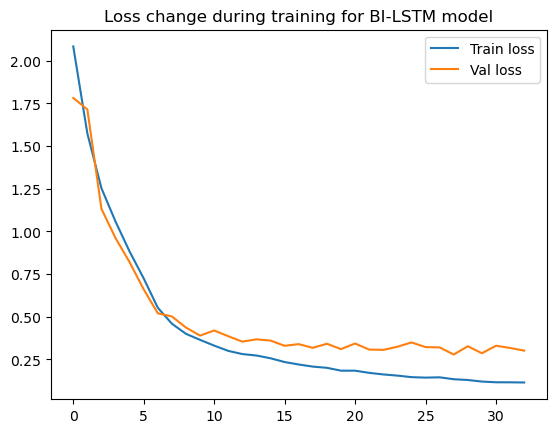

In [25]:
plt.plot(bilstm_train_losses_1)
plt.plot(bilstm_val_losses_1)
plt.title("Loss change during training for BI-LSTM model")
plt.legend(["Train loss", "Val loss"])
plt.show()

### BI-LSTM-1 evaluation

In [26]:
_ , train_acc_bilstm_1 = calc_accuracy(X_train, y_train, bilstm_model_1)
print(f"Train accuracy: {train_acc_bilstm_1}")

_ , val_acc_bilstm_1 = calc_accuracy(X_val, y_val, bilstm_model_1)
print(f"Train accuracy: {val_acc_bilstm_1}")

test_preds_bilstm_1, test_acc_bilstm_1 = calc_accuracy(X_test, y_test, bilstm_model_1)
print(f"Test accuracy: {test_acc_bilstm_1}")

Train accuracy: 0.9710864170892222
Train accuracy: 0.9181218471090415
Test accuracy: 0.9209193611219322


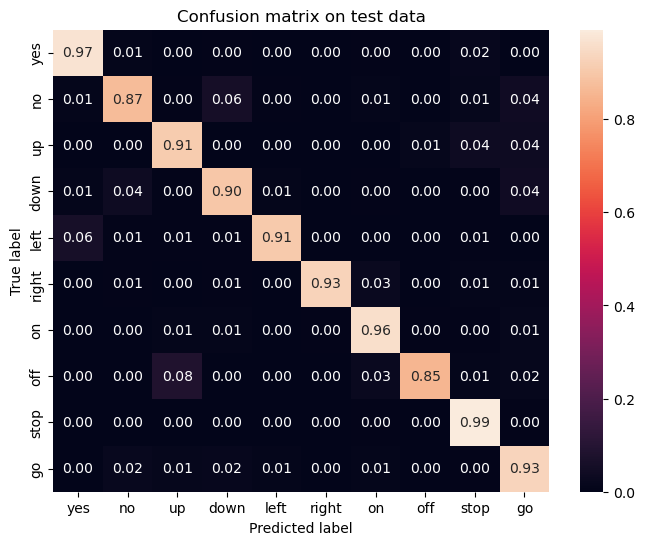

In [27]:
plt.figure(figsize=(8, 6))
result = confusion_matrix(y_test, test_preds_bilstm_1, normalize='true')
sns.heatmap(result, annot=True, fmt='.2f', xticklabels=CLASSES, yticklabels=CLASSES)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix on test data')
plt.show()

## BI-LSTM-2

In [20]:
input_size = 20
hidden_size = 32
dropout = 0.5
num_layers = 3
num_class = 10
fc_size = 32

bilstm_model_2 = BiLSTM(input_size, hidden_size, num_class, dropout, fc_size, num_layers).to(device)
bilstm_criterion_2 = nn.CrossEntropyLoss()
bilstm_optimizer_2 = optim.Adam(bilstm_model_2.parameters())

summary(bilstm_model_2, (1, 99, 20))

Layer (type:depth-idx)                   Output Shape              Param #
BiLSTM                                   [1, 10]                   10
├─LSTM: 1-1                              [1, 99, 64]               64,000
├─BatchNorm1d: 1-2                       [1, 64]                   128
├─Linear: 1-3                            [1, 32]                   2,080
├─Dropout: 1-4                           [1, 32]                   --
├─ReLU: 1-5                              [1, 32]                   --
├─BatchNorm1d: 1-6                       [1, 32]                   64
├─Linear: 1-7                            [1, 10]                   330
Total params: 66,612
Trainable params: 66,612
Non-trainable params: 0
Total mult-adds (M): 6.34
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.27
Estimated Total Size (MB): 0.33

In [21]:
train_dl = transform_to_data_loader(X_train, y_train, device=device)
val_dl = transform_to_data_loader(X_val, y_val, device=device)

bilstm_train_losses_2, bilstm_val_losses_2 = train_model(
    model=bilstm_model_2,
    criterion=bilstm_criterion_2,
    optimizer=bilstm_optimizer_2,
    train_loader=train_dl,
    val_loader=val_dl, 
    model_type="main", 
    epoch_count=100,
    device=device,
    early_stopping=True,
    patience=5
)

Epoch 1: 100%|██████████| 145/145 [00:01<00:00, 90.63it/s]


Epoch 1/100, Train Loss: 2.2676, Train Acc: 0.16, Val Loss: 2.0046, Val Acc: 0.25


Epoch 2: 100%|██████████| 145/145 [00:01<00:00, 102.47it/s]


Epoch 2/100, Train Loss: 1.9685, Train Acc: 0.28, Val Loss: 1.8361, Val Acc: 0.33


Epoch 3: 100%|██████████| 145/145 [00:01<00:00, 94.39it/s]


Epoch 3/100, Train Loss: 1.8606, Train Acc: 0.32, Val Loss: 1.7459, Val Acc: 0.37


Epoch 4: 100%|██████████| 145/145 [00:01<00:00, 91.14it/s]


Epoch 4/100, Train Loss: 1.7704, Train Acc: 0.37, Val Loss: 1.6058, Val Acc: 0.46


Epoch 5: 100%|██████████| 145/145 [00:01<00:00, 91.76it/s]


Epoch 5/100, Train Loss: 1.6274, Train Acc: 0.44, Val Loss: 1.4565, Val Acc: 0.51


Epoch 6: 100%|██████████| 145/145 [00:01<00:00, 84.84it/s]


Epoch 6/100, Train Loss: 1.4732, Train Acc: 0.49, Val Loss: 1.3000, Val Acc: 0.55


Epoch 7: 100%|██████████| 145/145 [00:02<00:00, 69.28it/s]


Epoch 7/100, Train Loss: 1.3284, Train Acc: 0.55, Val Loss: 1.2010, Val Acc: 0.59


Epoch 8: 100%|██████████| 145/145 [00:01<00:00, 75.21it/s]


Epoch 8/100, Train Loss: 1.2082, Train Acc: 0.60, Val Loss: 0.9992, Val Acc: 0.67


Epoch 9: 100%|██████████| 145/145 [00:01<00:00, 75.41it/s]


Epoch 9/100, Train Loss: 1.1145, Train Acc: 0.63, Val Loss: 0.9820, Val Acc: 0.68


Epoch 10: 100%|██████████| 145/145 [00:01<00:00, 87.31it/s]


Epoch 10/100, Train Loss: 1.0039, Train Acc: 0.67, Val Loss: 0.7961, Val Acc: 0.72


Epoch 11: 100%|██████████| 145/145 [00:01<00:00, 78.53it/s]


Epoch 11/100, Train Loss: 0.9287, Train Acc: 0.69, Val Loss: 0.8415, Val Acc: 0.71


Epoch 12: 100%|██████████| 145/145 [00:01<00:00, 90.30it/s]


Epoch 12/100, Train Loss: 0.8354, Train Acc: 0.73, Val Loss: 0.7414, Val Acc: 0.74


Epoch 13: 100%|██████████| 145/145 [00:01<00:00, 90.94it/s]


Epoch 13/100, Train Loss: 0.8000, Train Acc: 0.73, Val Loss: 0.7442, Val Acc: 0.73


Epoch 14: 100%|██████████| 145/145 [00:01<00:00, 77.54it/s]


Epoch 14/100, Train Loss: 0.7384, Train Acc: 0.75, Val Loss: 0.6289, Val Acc: 0.80


Epoch 15: 100%|██████████| 145/145 [00:01<00:00, 84.38it/s]


Epoch 15/100, Train Loss: 0.7014, Train Acc: 0.77, Val Loss: 0.5545, Val Acc: 0.82


Epoch 16: 100%|██████████| 145/145 [00:01<00:00, 89.23it/s]


Epoch 16/100, Train Loss: 0.6433, Train Acc: 0.80, Val Loss: 0.5346, Val Acc: 0.83


Epoch 17: 100%|██████████| 145/145 [00:01<00:00, 90.06it/s]


Epoch 17/100, Train Loss: 0.6001, Train Acc: 0.81, Val Loss: 0.5106, Val Acc: 0.82


Epoch 18: 100%|██████████| 145/145 [00:01<00:00, 84.92it/s]


Epoch 18/100, Train Loss: 0.5861, Train Acc: 0.83, Val Loss: 0.5175, Val Acc: 0.85


Epoch 19: 100%|██████████| 145/145 [00:01<00:00, 82.15it/s]


Epoch 19/100, Train Loss: 0.5409, Train Acc: 0.84, Val Loss: 0.4389, Val Acc: 0.86


Epoch 20: 100%|██████████| 145/145 [00:02<00:00, 71.05it/s]


Epoch 20/100, Train Loss: 0.5259, Train Acc: 0.84, Val Loss: 0.4250, Val Acc: 0.86


Epoch 21: 100%|██████████| 145/145 [00:01<00:00, 76.27it/s]


Epoch 21/100, Train Loss: 0.4975, Train Acc: 0.85, Val Loss: 0.4674, Val Acc: 0.85


Epoch 22: 100%|██████████| 145/145 [00:01<00:00, 82.20it/s]


Epoch 22/100, Train Loss: 0.4889, Train Acc: 0.86, Val Loss: 0.4187, Val Acc: 0.87


Epoch 23: 100%|██████████| 145/145 [00:01<00:00, 84.16it/s]


Epoch 23/100, Train Loss: 0.4626, Train Acc: 0.87, Val Loss: 0.4407, Val Acc: 0.86


Epoch 24: 100%|██████████| 145/145 [00:01<00:00, 85.34it/s]


Epoch 24/100, Train Loss: 0.4502, Train Acc: 0.87, Val Loss: 0.4009, Val Acc: 0.88


Epoch 25: 100%|██████████| 145/145 [00:01<00:00, 82.23it/s]


Epoch 25/100, Train Loss: 0.4324, Train Acc: 0.87, Val Loss: 0.3978, Val Acc: 0.88


Epoch 26: 100%|██████████| 145/145 [00:01<00:00, 83.58it/s]


Epoch 26/100, Train Loss: 0.4132, Train Acc: 0.88, Val Loss: 0.4512, Val Acc: 0.86


Epoch 27: 100%|██████████| 145/145 [00:01<00:00, 79.49it/s]


Epoch 27/100, Train Loss: 0.4087, Train Acc: 0.88, Val Loss: 0.4052, Val Acc: 0.89


Epoch 28: 100%|██████████| 145/145 [00:01<00:00, 75.39it/s]


Epoch 28/100, Train Loss: 0.3871, Train Acc: 0.89, Val Loss: 0.3829, Val Acc: 0.88


Epoch 29: 100%|██████████| 145/145 [00:01<00:00, 85.55it/s]


Epoch 29/100, Train Loss: 0.3874, Train Acc: 0.89, Val Loss: 0.4061, Val Acc: 0.88


Epoch 30: 100%|██████████| 145/145 [00:01<00:00, 80.49it/s]


Epoch 30/100, Train Loss: 0.3778, Train Acc: 0.89, Val Loss: 0.4349, Val Acc: 0.88


Epoch 31: 100%|██████████| 145/145 [00:02<00:00, 64.23it/s]


Epoch 31/100, Train Loss: 0.3577, Train Acc: 0.89, Val Loss: 0.4306, Val Acc: 0.89


Epoch 32: 100%|██████████| 145/145 [00:02<00:00, 64.32it/s]


Epoch 32/100, Train Loss: 0.3558, Train Acc: 0.89, Val Loss: 0.3997, Val Acc: 0.89


Epoch 33: 100%|██████████| 145/145 [00:02<00:00, 68.99it/s]


Epoch 33/100, Train Loss: 0.3425, Train Acc: 0.90, Val Loss: 0.3563, Val Acc: 0.90


Epoch 34: 100%|██████████| 145/145 [00:02<00:00, 64.12it/s]


Epoch 34/100, Train Loss: 0.3332, Train Acc: 0.91, Val Loss: 0.4009, Val Acc: 0.89


Epoch 35: 100%|██████████| 145/145 [00:01<00:00, 81.38it/s]


Epoch 35/100, Train Loss: 0.3235, Train Acc: 0.91, Val Loss: 0.3988, Val Acc: 0.90


Epoch 36: 100%|██████████| 145/145 [00:01<00:00, 83.81it/s]


Epoch 36/100, Train Loss: 0.3159, Train Acc: 0.91, Val Loss: 0.4074, Val Acc: 0.89


Epoch 37: 100%|██████████| 145/145 [00:01<00:00, 89.70it/s]


Epoch 37/100, Train Loss: 0.3105, Train Acc: 0.91, Val Loss: 0.3867, Val Acc: 0.90


Epoch 38: 100%|██████████| 145/145 [00:01<00:00, 91.60it/s]


Epoch 38/100, Train Loss: 0.3026, Train Acc: 0.91, Val Loss: 0.4002, Val Acc: 0.90
Early stopping


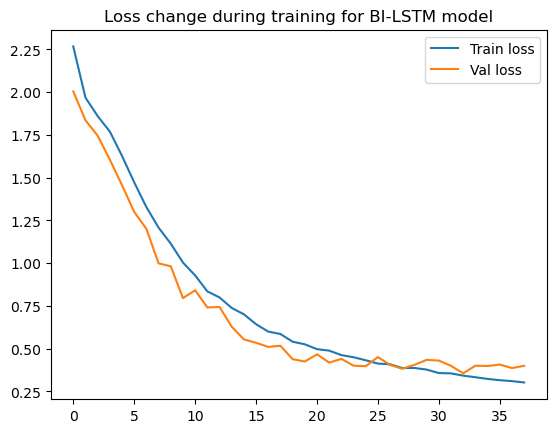

In [24]:
plt.plot(bilstm_train_losses_2)
plt.plot(bilstm_val_losses_2)
plt.title("Loss change during training for BI-LSTM model")
plt.legend(["Train loss", "Val loss"])
plt.show()

### BI-LSTM-2 evaluation

In [26]:
_ , train_acc_bilstm_2 = calc_accuracy(X_train, y_train, bilstm_model_2)
print(f"Train accuracy: {train_acc_bilstm_2}")

_ , val_acc_bilstm_2 = calc_accuracy(X_val, y_val, bilstm_model_2)
print(f"Train accuracy: {val_acc_bilstm_2}")

test_preds_bilstm_2, test_acc_bilstm_2 = calc_accuracy(X_test, y_test, bilstm_model_2)
print(f"Test accuracy: {test_acc_bilstm_2}")

Train accuracy: 0.9439529614845182
Train accuracy: 0.9002716336825767
Test accuracy: 0.8983248928710557


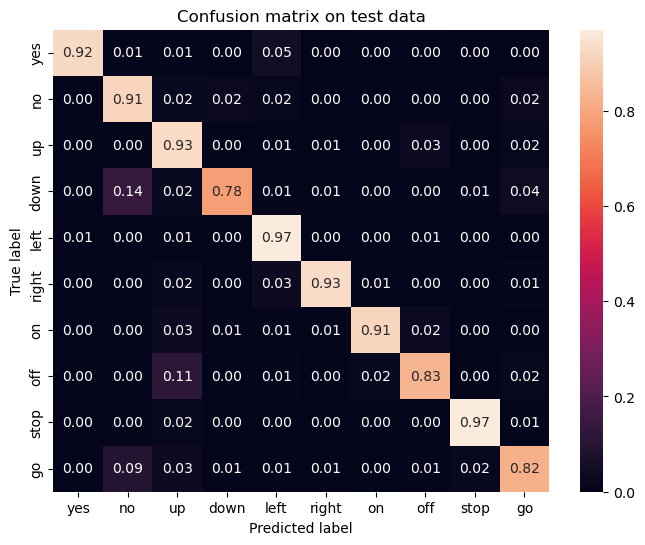

In [27]:
plt.figure(figsize=(8, 6))
result = confusion_matrix(y_test, test_preds_bilstm_2, normalize='true')
sns.heatmap(result, annot=True, fmt='.2f', xticklabels=CLASSES, yticklabels=CLASSES)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix on test data')
plt.show()

## GRU-1

In [91]:
input_size = 20
hidden_size = 32
dropout = 0.5
num_layers = 1
num_class = 10

gru_model_1 = GRU(input_size, hidden_size, num_class, dropout, num_layers).to(device)
gru_criterion_1 = nn.CrossEntropyLoss()
gru_optimizer_1 = optim.Adam(gru_model_1.parameters())

summary(gru_model_1, (1, 99, 20))

Layer (type:depth-idx)                   Output Shape              Param #
GRU                                      [1, 10]                   --
├─GRU: 1-1                               [1, 99, 32]               5,184
├─Linear: 1-2                            [1, 10]                   330
Total params: 5,514
Trainable params: 5,514
Non-trainable params: 0
Total mult-adds (M): 0.51
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 0.02
Estimated Total Size (MB): 0.06

In [92]:
train_dl = transform_to_data_loader(X_train, y_train, device=device)
val_dl = transform_to_data_loader(X_val, y_val, device=device)

gru_train_losses_1, gru_val_losses_1 = train_model(
    model=gru_model_1,
    criterion=gru_criterion_1,
    optimizer=gru_optimizer_1,
    train_loader=train_dl,
    val_loader=val_dl, 
    model_type="main", 
    epoch_count=100,
    device=device,
    early_stopping=True,
    patience=5
)

Epoch 1: 100%|██████████| 145/145 [00:00<00:00, 178.13it/s]


Epoch 1/100, Train Loss: 2.2229, Train Acc: 0.18, Val Loss: 2.0777, Val Acc: 0.25


Epoch 2: 100%|██████████| 145/145 [00:00<00:00, 186.86it/s]


Epoch 2/100, Train Loss: 1.9533, Train Acc: 0.30, Val Loss: 1.8192, Val Acc: 0.33


Epoch 3: 100%|██████████| 145/145 [00:00<00:00, 185.43it/s]


Epoch 3/100, Train Loss: 1.7148, Train Acc: 0.38, Val Loss: 1.6264, Val Acc: 0.42


Epoch 4: 100%|██████████| 145/145 [00:00<00:00, 178.57it/s]


Epoch 4/100, Train Loss: 1.5231, Train Acc: 0.46, Val Loss: 1.4407, Val Acc: 0.49


Epoch 5: 100%|██████████| 145/145 [00:00<00:00, 182.04it/s]


Epoch 5/100, Train Loss: 1.3489, Train Acc: 0.52, Val Loss: 1.3448, Val Acc: 0.51


Epoch 6: 100%|██████████| 145/145 [00:00<00:00, 184.96it/s]


Epoch 6/100, Train Loss: 1.2137, Train Acc: 0.57, Val Loss: 1.1854, Val Acc: 0.59


Epoch 7: 100%|██████████| 145/145 [00:00<00:00, 188.31it/s]


Epoch 7/100, Train Loss: 1.0809, Train Acc: 0.62, Val Loss: 1.0333, Val Acc: 0.65


Epoch 8: 100%|██████████| 145/145 [00:00<00:00, 173.16it/s]


Epoch 8/100, Train Loss: 0.9440, Train Acc: 0.68, Val Loss: 0.9095, Val Acc: 0.70


Epoch 9: 100%|██████████| 145/145 [00:00<00:00, 175.33it/s]


Epoch 9/100, Train Loss: 0.8385, Train Acc: 0.72, Val Loss: 0.8365, Val Acc: 0.72


Epoch 10: 100%|██████████| 145/145 [00:00<00:00, 183.03it/s]


Epoch 10/100, Train Loss: 0.7613, Train Acc: 0.75, Val Loss: 0.7432, Val Acc: 0.76


Epoch 11: 100%|██████████| 145/145 [00:00<00:00, 186.14it/s]


Epoch 11/100, Train Loss: 0.6957, Train Acc: 0.77, Val Loss: 0.6685, Val Acc: 0.79


Epoch 12: 100%|██████████| 145/145 [00:00<00:00, 187.10it/s]


Epoch 12/100, Train Loss: 0.6445, Train Acc: 0.79, Val Loss: 0.6350, Val Acc: 0.80


Epoch 13: 100%|██████████| 145/145 [00:00<00:00, 164.22it/s]


Epoch 13/100, Train Loss: 0.5975, Train Acc: 0.81, Val Loss: 0.6111, Val Acc: 0.81


Epoch 14: 100%|██████████| 145/145 [00:00<00:00, 159.69it/s]


Epoch 14/100, Train Loss: 0.5608, Train Acc: 0.82, Val Loss: 0.5606, Val Acc: 0.83


Epoch 15: 100%|██████████| 145/145 [00:00<00:00, 171.34it/s]


Epoch 15/100, Train Loss: 0.5260, Train Acc: 0.83, Val Loss: 0.5493, Val Acc: 0.83


Epoch 16: 100%|██████████| 145/145 [00:00<00:00, 171.39it/s]


Epoch 16/100, Train Loss: 0.4996, Train Acc: 0.84, Val Loss: 0.5248, Val Acc: 0.84


Epoch 17: 100%|██████████| 145/145 [00:00<00:00, 178.38it/s]


Epoch 17/100, Train Loss: 0.4787, Train Acc: 0.85, Val Loss: 0.4943, Val Acc: 0.85


Epoch 18: 100%|██████████| 145/145 [00:00<00:00, 160.06it/s]


Epoch 18/100, Train Loss: 0.4617, Train Acc: 0.86, Val Loss: 0.4977, Val Acc: 0.84


Epoch 19: 100%|██████████| 145/145 [00:00<00:00, 170.39it/s]


Epoch 19/100, Train Loss: 0.4464, Train Acc: 0.86, Val Loss: 0.4741, Val Acc: 0.86


Epoch 20: 100%|██████████| 145/145 [00:00<00:00, 175.90it/s]


Epoch 20/100, Train Loss: 0.4278, Train Acc: 0.87, Val Loss: 0.4618, Val Acc: 0.85


Epoch 21: 100%|██████████| 145/145 [00:00<00:00, 181.02it/s]


Epoch 21/100, Train Loss: 0.4164, Train Acc: 0.87, Val Loss: 0.4480, Val Acc: 0.86


Epoch 22: 100%|██████████| 145/145 [00:00<00:00, 185.19it/s]


Epoch 22/100, Train Loss: 0.4021, Train Acc: 0.88, Val Loss: 0.4627, Val Acc: 0.85


Epoch 23: 100%|██████████| 145/145 [00:00<00:00, 176.80it/s]


Epoch 23/100, Train Loss: 0.3892, Train Acc: 0.88, Val Loss: 0.4373, Val Acc: 0.86


Epoch 24: 100%|██████████| 145/145 [00:00<00:00, 165.34it/s]


Epoch 24/100, Train Loss: 0.3836, Train Acc: 0.88, Val Loss: 0.4272, Val Acc: 0.86


Epoch 25: 100%|██████████| 145/145 [00:00<00:00, 180.51it/s]


Epoch 25/100, Train Loss: 0.3736, Train Acc: 0.88, Val Loss: 0.4312, Val Acc: 0.87


Epoch 26: 100%|██████████| 145/145 [00:00<00:00, 183.97it/s]


Epoch 26/100, Train Loss: 0.3667, Train Acc: 0.89, Val Loss: 0.4179, Val Acc: 0.87


Epoch 27: 100%|██████████| 145/145 [00:00<00:00, 173.45it/s]


Epoch 27/100, Train Loss: 0.3560, Train Acc: 0.89, Val Loss: 0.4333, Val Acc: 0.86


Epoch 28: 100%|██████████| 145/145 [00:00<00:00, 176.51it/s]


Epoch 28/100, Train Loss: 0.3493, Train Acc: 0.89, Val Loss: 0.4135, Val Acc: 0.87


Epoch 29: 100%|██████████| 145/145 [00:00<00:00, 166.67it/s]


Epoch 29/100, Train Loss: 0.3401, Train Acc: 0.89, Val Loss: 0.4062, Val Acc: 0.87


Epoch 30: 100%|██████████| 145/145 [00:00<00:00, 183.24it/s]


Epoch 30/100, Train Loss: 0.3360, Train Acc: 0.89, Val Loss: 0.3984, Val Acc: 0.87


Epoch 31: 100%|██████████| 145/145 [00:00<00:00, 185.42it/s]


Epoch 31/100, Train Loss: 0.3277, Train Acc: 0.90, Val Loss: 0.3988, Val Acc: 0.87


Epoch 32: 100%|██████████| 145/145 [00:00<00:00, 186.30it/s]


Epoch 32/100, Train Loss: 0.3219, Train Acc: 0.90, Val Loss: 0.3864, Val Acc: 0.88


Epoch 33: 100%|██████████| 145/145 [00:00<00:00, 181.30it/s]


Epoch 33/100, Train Loss: 0.3127, Train Acc: 0.90, Val Loss: 0.4044, Val Acc: 0.87


Epoch 34: 100%|██████████| 145/145 [00:00<00:00, 156.59it/s]


Epoch 34/100, Train Loss: 0.3103, Train Acc: 0.90, Val Loss: 0.3852, Val Acc: 0.88


Epoch 35: 100%|██████████| 145/145 [00:00<00:00, 173.77it/s]


Epoch 35/100, Train Loss: 0.3009, Train Acc: 0.91, Val Loss: 0.3962, Val Acc: 0.88


Epoch 36: 100%|██████████| 145/145 [00:00<00:00, 186.37it/s]


Epoch 36/100, Train Loss: 0.2980, Train Acc: 0.91, Val Loss: 0.3757, Val Acc: 0.88


Epoch 37: 100%|██████████| 145/145 [00:00<00:00, 170.59it/s]


Epoch 37/100, Train Loss: 0.2912, Train Acc: 0.91, Val Loss: 0.3765, Val Acc: 0.88


Epoch 38: 100%|██████████| 145/145 [00:00<00:00, 177.12it/s]


Epoch 38/100, Train Loss: 0.2852, Train Acc: 0.91, Val Loss: 0.3777, Val Acc: 0.88


Epoch 39: 100%|██████████| 145/145 [00:00<00:00, 170.39it/s]


Epoch 39/100, Train Loss: 0.2791, Train Acc: 0.91, Val Loss: 0.3710, Val Acc: 0.88


Epoch 40: 100%|██████████| 145/145 [00:00<00:00, 172.15it/s]


Epoch 40/100, Train Loss: 0.2738, Train Acc: 0.91, Val Loss: 0.3667, Val Acc: 0.88


Epoch 41: 100%|██████████| 145/145 [00:00<00:00, 179.45it/s]


Epoch 41/100, Train Loss: 0.2671, Train Acc: 0.92, Val Loss: 0.3642, Val Acc: 0.88


Epoch 42: 100%|██████████| 145/145 [00:00<00:00, 184.08it/s]


Epoch 42/100, Train Loss: 0.2655, Train Acc: 0.92, Val Loss: 0.3811, Val Acc: 0.88


Epoch 43: 100%|██████████| 145/145 [00:00<00:00, 176.65it/s]


Epoch 43/100, Train Loss: 0.2603, Train Acc: 0.92, Val Loss: 0.3654, Val Acc: 0.89


Epoch 44: 100%|██████████| 145/145 [00:00<00:00, 167.14it/s]


Epoch 44/100, Train Loss: 0.2546, Train Acc: 0.92, Val Loss: 0.3519, Val Acc: 0.89


Epoch 45: 100%|██████████| 145/145 [00:00<00:00, 179.03it/s]


Epoch 45/100, Train Loss: 0.2531, Train Acc: 0.92, Val Loss: 0.3578, Val Acc: 0.89


Epoch 46: 100%|██████████| 145/145 [00:00<00:00, 176.21it/s]


Epoch 46/100, Train Loss: 0.2487, Train Acc: 0.92, Val Loss: 0.3533, Val Acc: 0.89


Epoch 47: 100%|██████████| 145/145 [00:00<00:00, 174.28it/s]


Epoch 47/100, Train Loss: 0.2433, Train Acc: 0.92, Val Loss: 0.3683, Val Acc: 0.88


Epoch 48: 100%|██████████| 145/145 [00:00<00:00, 161.07it/s]


Epoch 48/100, Train Loss: 0.2419, Train Acc: 0.92, Val Loss: 0.3620, Val Acc: 0.89


Epoch 49: 100%|██████████| 145/145 [00:00<00:00, 162.01it/s]


Epoch 49/100, Train Loss: 0.2362, Train Acc: 0.93, Val Loss: 0.3817, Val Acc: 0.89
Early stopping


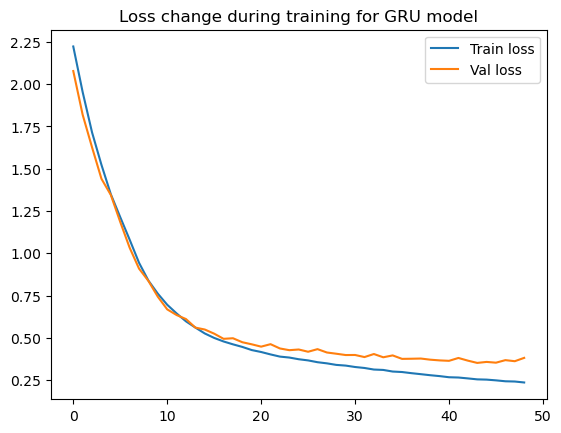

In [93]:
plt.plot(gru_train_losses_1)
plt.plot(gru_val_losses_1)
plt.title("Loss change during training for GRU model")
plt.legend(["Train loss", "Val loss"])
plt.show()

### GRU-1 evaluation

In [94]:
_, train_acc_gru_1 = calc_accuracy(X_train, y_train, gru_model_1)
print(f"Train accuracy: {train_acc_gru_1}")


_, val_acc_gru_1 = calc_accuracy(X_val, y_val, gru_model_1)
print(f"Val accuracy: {val_acc_gru_1}")

test_preds_gru_1, test_acc_gru_1 = calc_accuracy(X_test, y_test, gru_model_1)
print(f"Test accuracy: {test_acc_gru_1}")

Train accuracy: 0.9231848095803215
Val accuracy: 0.8855258051998448
Test accuracy: 0.8827425009738995


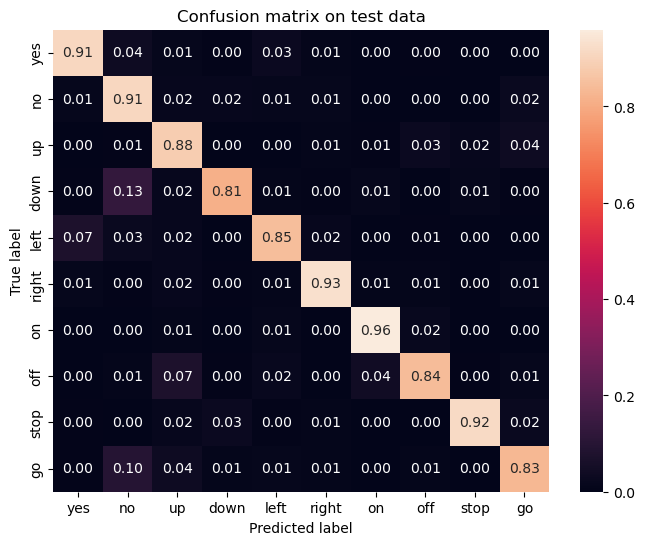

In [96]:
plt.figure(figsize=(8, 6))
result = confusion_matrix(y_test, test_preds_gru_1, normalize='true')
sns.heatmap(result, annot=True, fmt='.2f', xticklabels=CLASSES, yticklabels=CLASSES)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix on test data')
plt.show()

## GRU-2

In [105]:
input_size = 20
hidden_size = 64
dropout = 0.5
num_layers = 4
num_class = 10

gru_model_2 = GRU(input_size, hidden_size, num_class, dropout, num_layers).to(device)
gru_criterion_2 = nn.CrossEntropyLoss()
gru_optimizer_2 = optim.Adam(gru_model_2.parameters())

summary(gru_model_2, (1, 99, 20))

Layer (type:depth-idx)                   Output Shape              Param #
GRU                                      [1, 10]                   --
├─GRU: 1-1                               [1, 99, 64]               91,392
├─Linear: 1-2                            [1, 10]                   650
Total params: 92,042
Trainable params: 92,042
Non-trainable params: 0
Total mult-adds (M): 9.05
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.37
Estimated Total Size (MB): 0.43

In [106]:
gru_train_losses_2, gru_val_losses_2 = train_model(
    model=gru_model_2,
    criterion=gru_criterion_2,
    optimizer=gru_optimizer_2,
    train_loader=train_dl,
    val_loader=val_dl, 
    model_type="main", 
    epoch_count=100,
    device=device,
    early_stopping=True,
    patience=5
)

Epoch 1: 100%|██████████| 145/145 [00:02<00:00, 68.99it/s]


Epoch 1/100, Train Loss: 2.0992, Train Acc: 0.21, Val Loss: 1.8357, Val Acc: 0.32


Epoch 2: 100%|██████████| 145/145 [00:01<00:00, 79.58it/s]


Epoch 2/100, Train Loss: 1.5577, Train Acc: 0.43, Val Loss: 1.2778, Val Acc: 0.55


Epoch 3: 100%|██████████| 145/145 [00:01<00:00, 80.84it/s]


Epoch 3/100, Train Loss: 1.1176, Train Acc: 0.61, Val Loss: 0.9234, Val Acc: 0.67


Epoch 4: 100%|██████████| 145/145 [00:01<00:00, 78.88it/s]


Epoch 4/100, Train Loss: 0.8316, Train Acc: 0.72, Val Loss: 0.6883, Val Acc: 0.77


Epoch 5: 100%|██████████| 145/145 [00:01<00:00, 80.07it/s]


Epoch 5/100, Train Loss: 0.6014, Train Acc: 0.81, Val Loss: 0.5332, Val Acc: 0.83


Epoch 6: 100%|██████████| 145/145 [00:01<00:00, 80.71it/s]


Epoch 6/100, Train Loss: 0.4899, Train Acc: 0.84, Val Loss: 0.5005, Val Acc: 0.83


Epoch 7: 100%|██████████| 145/145 [00:01<00:00, 78.90it/s]


Epoch 7/100, Train Loss: 0.4175, Train Acc: 0.86, Val Loss: 0.3804, Val Acc: 0.88


Epoch 8: 100%|██████████| 145/145 [00:01<00:00, 79.82it/s]


Epoch 8/100, Train Loss: 0.3669, Train Acc: 0.88, Val Loss: 0.3570, Val Acc: 0.89


Epoch 9: 100%|██████████| 145/145 [00:01<00:00, 80.24it/s]


Epoch 9/100, Train Loss: 0.3249, Train Acc: 0.89, Val Loss: 0.3701, Val Acc: 0.89


Epoch 10: 100%|██████████| 145/145 [00:01<00:00, 78.04it/s]


Epoch 10/100, Train Loss: 0.2949, Train Acc: 0.90, Val Loss: 0.3264, Val Acc: 0.89


Epoch 11: 100%|██████████| 145/145 [00:01<00:00, 79.57it/s]


Epoch 11/100, Train Loss: 0.2749, Train Acc: 0.91, Val Loss: 0.3183, Val Acc: 0.90


Epoch 12: 100%|██████████| 145/145 [00:01<00:00, 79.97it/s]


Epoch 12/100, Train Loss: 0.2485, Train Acc: 0.92, Val Loss: 0.2986, Val Acc: 0.91


Epoch 13: 100%|██████████| 145/145 [00:01<00:00, 77.71it/s]


Epoch 13/100, Train Loss: 0.2302, Train Acc: 0.92, Val Loss: 0.2841, Val Acc: 0.91


Epoch 14: 100%|██████████| 145/145 [00:01<00:00, 78.45it/s]


Epoch 14/100, Train Loss: 0.2148, Train Acc: 0.93, Val Loss: 0.2875, Val Acc: 0.91


Epoch 15: 100%|██████████| 145/145 [00:01<00:00, 79.42it/s]


Epoch 15/100, Train Loss: 0.1995, Train Acc: 0.93, Val Loss: 0.2650, Val Acc: 0.92


Epoch 16: 100%|██████████| 145/145 [00:01<00:00, 77.63it/s]


Epoch 16/100, Train Loss: 0.1880, Train Acc: 0.94, Val Loss: 0.2657, Val Acc: 0.92


Epoch 17: 100%|██████████| 145/145 [00:01<00:00, 80.23it/s]


Epoch 17/100, Train Loss: 0.1759, Train Acc: 0.94, Val Loss: 0.2622, Val Acc: 0.92


Epoch 18: 100%|██████████| 145/145 [00:01<00:00, 78.85it/s]


Epoch 18/100, Train Loss: 0.1724, Train Acc: 0.94, Val Loss: 0.2652, Val Acc: 0.92


Epoch 19: 100%|██████████| 145/145 [00:01<00:00, 76.66it/s]


Epoch 19/100, Train Loss: 0.1699, Train Acc: 0.94, Val Loss: 0.2746, Val Acc: 0.92


Epoch 20: 100%|██████████| 145/145 [00:01<00:00, 79.23it/s]


Epoch 20/100, Train Loss: 0.1603, Train Acc: 0.95, Val Loss: 0.2625, Val Acc: 0.92


Epoch 21: 100%|██████████| 145/145 [00:01<00:00, 79.65it/s]


Epoch 21/100, Train Loss: 0.1565, Train Acc: 0.95, Val Loss: 0.2580, Val Acc: 0.93


Epoch 22: 100%|██████████| 145/145 [00:01<00:00, 77.02it/s]


Epoch 22/100, Train Loss: 0.1457, Train Acc: 0.95, Val Loss: 0.2517, Val Acc: 0.93


Epoch 23: 100%|██████████| 145/145 [00:01<00:00, 77.71it/s]


Epoch 23/100, Train Loss: 0.1386, Train Acc: 0.95, Val Loss: 0.2528, Val Acc: 0.93


Epoch 24: 100%|██████████| 145/145 [00:01<00:00, 78.89it/s]


Epoch 24/100, Train Loss: 0.1318, Train Acc: 0.96, Val Loss: 0.2524, Val Acc: 0.93


Epoch 25: 100%|██████████| 145/145 [00:01<00:00, 79.18it/s]


Epoch 25/100, Train Loss: 0.1306, Train Acc: 0.96, Val Loss: 0.2702, Val Acc: 0.93


Epoch 26: 100%|██████████| 145/145 [00:01<00:00, 80.02it/s]


Epoch 26/100, Train Loss: 0.1265, Train Acc: 0.96, Val Loss: 0.2711, Val Acc: 0.92


Epoch 27: 100%|██████████| 145/145 [00:01<00:00, 75.48it/s]


Epoch 27/100, Train Loss: 0.1193, Train Acc: 0.96, Val Loss: 0.2844, Val Acc: 0.93
Early stopping


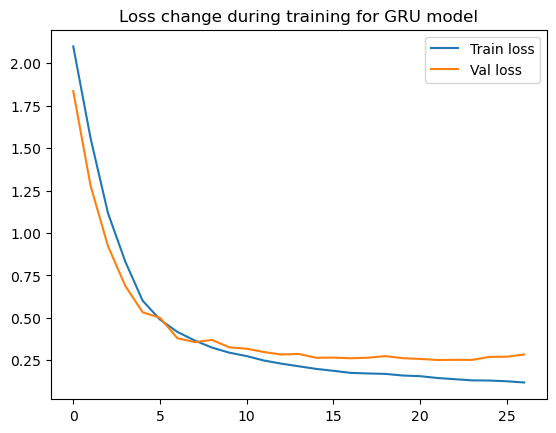

In [107]:
plt.plot(gru_train_losses_2)
plt.plot(gru_val_losses_2)
plt.title("Loss change during training for GRU model")
plt.legend(["Train loss", "Val loss"])
plt.show()

### GRU-2 evaluation

In [108]:
_, train_acc_gru_2 = calc_accuracy(X_train, y_train, gru_model_2)
print(f"Train accuracy: {train_acc_gru_2}")

_, val_acc_gru_2 = calc_accuracy(X_val, y_val, gru_model_2)
print(f"Val accuracy: {val_acc_gru_2}")

test_preds_gru_2, test_acc_gru_2 = calc_accuracy(X_test, y_test, gru_model_2)
print(f"Test accuracy: {test_acc_gru_2}")

Train accuracy: 0.9714640198511166
Val accuracy: 0.927046953822274
Test accuracy: 0.9318270354499416


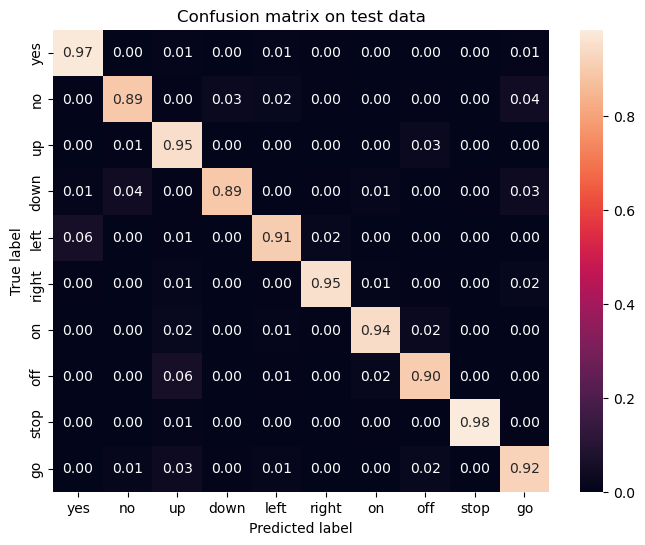

In [109]:
plt.figure(figsize=(8, 6))
result = confusion_matrix(y_test, test_preds_gru_2, normalize='true')
sns.heatmap(result, annot=True, fmt='.2f', xticklabels=CLASSES, yticklabels=CLASSES)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix on test data')
plt.show()

## Transformer-1

In [7]:
d_model = 20
n_head = 4
num_class = 10
num_layers = 4
dropout = 0.4
fc_size = 64

transformer_model_1 = Transformer(d_model, n_head, num_layers, num_class, dropout, fc_size).to(device)
transformer_criterion_1 = nn.CrossEntropyLoss()
transformer_optimizer_1 = optim.Adam(transformer_model_1.parameters())

summary(transformer_model_1, (1, 99, 20))

Layer (type:depth-idx)                        Output Shape              Param #
Transformer                                   [1, 10]                   85,748
├─TransformerEncoder: 1-1                     [1, 99, 20]               --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 99, 20]               85,748
│    │    └─TransformerEncoderLayer: 3-2      [1, 99, 20]               85,748
│    │    └─TransformerEncoderLayer: 3-3      [1, 99, 20]               85,748
│    │    └─TransformerEncoderLayer: 3-4      [1, 99, 20]               85,748
├─Dropout: 1-2                                [1, 20]                   --
├─BatchNorm1d: 1-3                            [1, 20]                   40
├─Linear: 1-4                                 [1, 64]                   1,344
├─Dropout: 1-5                                [1, 64]                   --
├─ReLU: 1-6                                   [1, 64]                   

In [9]:
train_dl = transform_to_data_loader(X_train, y_train, device=device)
val_dl = transform_to_data_loader(X_val, y_val, device=device)

transformer_train_losses_1, transformer_val_losses_1 = train_model(
    model=transformer_model_1,
    criterion=transformer_criterion_1,
    optimizer=transformer_optimizer_1,
    train_loader=train_dl,
    val_loader=val_dl, 
    model_type="main", 
    epoch_count=200,
    device=device,
    early_stopping=True,
    patience=10
)

Epoch 1:   0%|          | 0/145 [00:00<?, ?it/s]c:\Users\lukgr\anaconda3\envs\venv\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
Epoch 1: 100%|██████████| 145/145 [00:14<00:00, 10.24it/s]


Epoch 1/200, Train Loss: 2.2622, Train Acc: 0.16, Val Loss: 2.1482, Val Acc: 0.19


Epoch 2: 100%|██████████| 145/145 [00:13<00:00, 10.75it/s]


Epoch 2/200, Train Loss: 2.0012, Train Acc: 0.24, Val Loss: 1.9288, Val Acc: 0.29


Epoch 3: 100%|██████████| 145/145 [00:13<00:00, 10.70it/s]


Epoch 3/200, Train Loss: 1.8521, Train Acc: 0.29, Val Loss: 1.6448, Val Acc: 0.36


Epoch 4: 100%|██████████| 145/145 [00:13<00:00, 10.68it/s]


Epoch 4/200, Train Loss: 1.6775, Train Acc: 0.35, Val Loss: 1.4797, Val Acc: 0.43


Epoch 5: 100%|██████████| 145/145 [00:13<00:00, 10.69it/s]


Epoch 5/200, Train Loss: 1.5619, Train Acc: 0.40, Val Loss: 1.4859, Val Acc: 0.42


Epoch 6: 100%|██████████| 145/145 [00:13<00:00, 10.56it/s]


Epoch 6/200, Train Loss: 1.4925, Train Acc: 0.42, Val Loss: 1.3363, Val Acc: 0.47


Epoch 7: 100%|██████████| 145/145 [00:14<00:00,  9.82it/s]


Epoch 7/200, Train Loss: 1.4247, Train Acc: 0.45, Val Loss: 1.2947, Val Acc: 0.49


Epoch 8: 100%|██████████| 145/145 [00:15<00:00,  9.49it/s]


Epoch 8/200, Train Loss: 1.3792, Train Acc: 0.46, Val Loss: 1.2539, Val Acc: 0.51


Epoch 9: 100%|██████████| 145/145 [00:14<00:00,  9.85it/s]


Epoch 9/200, Train Loss: 1.3496, Train Acc: 0.48, Val Loss: 1.2444, Val Acc: 0.52


Epoch 10: 100%|██████████| 145/145 [00:14<00:00,  9.98it/s]


Epoch 10/200, Train Loss: 1.3141, Train Acc: 0.49, Val Loss: 1.3099, Val Acc: 0.51


Epoch 11: 100%|██████████| 145/145 [00:14<00:00,  9.78it/s]


Epoch 11/200, Train Loss: 1.2784, Train Acc: 0.51, Val Loss: 1.1203, Val Acc: 0.57


Epoch 12: 100%|██████████| 145/145 [00:15<00:00,  9.38it/s]


Epoch 12/200, Train Loss: 1.2458, Train Acc: 0.52, Val Loss: 1.2415, Val Acc: 0.55


Epoch 13: 100%|██████████| 145/145 [00:15<00:00,  9.45it/s]


Epoch 13/200, Train Loss: 1.2329, Train Acc: 0.53, Val Loss: 1.1768, Val Acc: 0.58


Epoch 14: 100%|██████████| 145/145 [00:14<00:00,  9.75it/s]


Epoch 14/200, Train Loss: 1.2045, Train Acc: 0.54, Val Loss: 1.1213, Val Acc: 0.58


Epoch 15: 100%|██████████| 145/145 [00:14<00:00,  9.96it/s]


Epoch 15/200, Train Loss: 1.1783, Train Acc: 0.56, Val Loss: 1.1698, Val Acc: 0.57


Epoch 16: 100%|██████████| 145/145 [00:14<00:00,  9.70it/s]


Epoch 16/200, Train Loss: 1.1510, Train Acc: 0.57, Val Loss: 1.1209, Val Acc: 0.60


Epoch 17: 100%|██████████| 145/145 [00:15<00:00,  9.53it/s]


Epoch 17/200, Train Loss: 1.1239, Train Acc: 0.58, Val Loss: 1.1457, Val Acc: 0.62


Epoch 18: 100%|██████████| 145/145 [00:14<00:00, 10.12it/s]


Epoch 18/200, Train Loss: 1.0992, Train Acc: 0.59, Val Loss: 1.0316, Val Acc: 0.64


Epoch 19: 100%|██████████| 145/145 [00:14<00:00, 10.10it/s]


Epoch 19/200, Train Loss: 1.0924, Train Acc: 0.60, Val Loss: 1.1800, Val Acc: 0.62


Epoch 20: 100%|██████████| 145/145 [00:14<00:00,  9.89it/s]


Epoch 20/200, Train Loss: 1.0657, Train Acc: 0.61, Val Loss: 1.0899, Val Acc: 0.62


Epoch 21: 100%|██████████| 145/145 [00:14<00:00,  9.75it/s]


Epoch 21/200, Train Loss: 1.0495, Train Acc: 0.62, Val Loss: 1.1311, Val Acc: 0.63


Epoch 22: 100%|██████████| 145/145 [00:14<00:00, 10.00it/s]


Epoch 22/200, Train Loss: 1.0228, Train Acc: 0.63, Val Loss: 1.0256, Val Acc: 0.66


Epoch 23: 100%|██████████| 145/145 [00:14<00:00,  9.79it/s]


Epoch 23/200, Train Loss: 1.0132, Train Acc: 0.64, Val Loss: 1.0730, Val Acc: 0.67


Epoch 24: 100%|██████████| 145/145 [00:14<00:00,  9.81it/s]


Epoch 24/200, Train Loss: 0.9910, Train Acc: 0.65, Val Loss: 0.9228, Val Acc: 0.71


Epoch 25: 100%|██████████| 145/145 [00:14<00:00, 10.02it/s]


Epoch 25/200, Train Loss: 0.9872, Train Acc: 0.66, Val Loss: 1.0481, Val Acc: 0.66


Epoch 26: 100%|██████████| 145/145 [00:14<00:00, 10.11it/s]


Epoch 26/200, Train Loss: 0.9601, Train Acc: 0.67, Val Loss: 0.9819, Val Acc: 0.70


Epoch 27: 100%|██████████| 145/145 [00:14<00:00, 10.05it/s]


Epoch 27/200, Train Loss: 0.9529, Train Acc: 0.67, Val Loss: 1.0874, Val Acc: 0.68


Epoch 28: 100%|██████████| 145/145 [00:14<00:00, 10.02it/s]


Epoch 28/200, Train Loss: 0.9324, Train Acc: 0.68, Val Loss: 1.1477, Val Acc: 0.67


Epoch 29: 100%|██████████| 145/145 [00:14<00:00, 10.00it/s]


Epoch 29/200, Train Loss: 0.9276, Train Acc: 0.69, Val Loss: 1.0337, Val Acc: 0.71


Epoch 30: 100%|██████████| 145/145 [00:15<00:00,  9.53it/s]


Epoch 30/200, Train Loss: 0.9052, Train Acc: 0.69, Val Loss: 1.0309, Val Acc: 0.71


Epoch 31: 100%|██████████| 145/145 [00:14<00:00,  9.69it/s]


Epoch 31/200, Train Loss: 0.9129, Train Acc: 0.69, Val Loss: 1.2360, Val Acc: 0.69


Epoch 32: 100%|██████████| 145/145 [00:14<00:00,  9.67it/s]


Epoch 32/200, Train Loss: 0.8860, Train Acc: 0.71, Val Loss: 1.1226, Val Acc: 0.71


Epoch 33: 100%|██████████| 145/145 [00:14<00:00,  9.87it/s]


Epoch 33/200, Train Loss: 0.8905, Train Acc: 0.70, Val Loss: 0.8768, Val Acc: 0.75


Epoch 34: 100%|██████████| 145/145 [00:15<00:00,  9.57it/s]


Epoch 34/200, Train Loss: 0.8705, Train Acc: 0.71, Val Loss: 1.0409, Val Acc: 0.73


Epoch 35: 100%|██████████| 145/145 [00:16<00:00,  9.06it/s]


Epoch 35/200, Train Loss: 0.8701, Train Acc: 0.71, Val Loss: 0.8918, Val Acc: 0.77


Epoch 36: 100%|██████████| 145/145 [00:16<00:00,  9.01it/s]


Epoch 36/200, Train Loss: 0.8320, Train Acc: 0.72, Val Loss: 0.9991, Val Acc: 0.75


Epoch 37: 100%|██████████| 145/145 [00:15<00:00,  9.40it/s]


Epoch 37/200, Train Loss: 0.8299, Train Acc: 0.73, Val Loss: 0.9600, Val Acc: 0.77


Epoch 38: 100%|██████████| 145/145 [00:15<00:00,  9.35it/s]


Epoch 38/200, Train Loss: 0.8266, Train Acc: 0.73, Val Loss: 0.8428, Val Acc: 0.78


Epoch 39: 100%|██████████| 145/145 [00:15<00:00,  9.07it/s]


Epoch 39/200, Train Loss: 0.8147, Train Acc: 0.74, Val Loss: 1.0910, Val Acc: 0.74


Epoch 40: 100%|██████████| 145/145 [00:15<00:00,  9.14it/s]


Epoch 40/200, Train Loss: 0.7955, Train Acc: 0.75, Val Loss: 1.1366, Val Acc: 0.73


Epoch 41: 100%|██████████| 145/145 [00:15<00:00,  9.49it/s]


Epoch 41/200, Train Loss: 0.7849, Train Acc: 0.75, Val Loss: 0.8779, Val Acc: 0.77


Epoch 42: 100%|██████████| 145/145 [00:16<00:00,  8.95it/s]


Epoch 42/200, Train Loss: 0.7753, Train Acc: 0.75, Val Loss: 0.9023, Val Acc: 0.77


Epoch 43: 100%|██████████| 145/145 [00:16<00:00,  9.02it/s]


Epoch 43/200, Train Loss: 0.7575, Train Acc: 0.76, Val Loss: 1.0208, Val Acc: 0.77


Epoch 44: 100%|██████████| 145/145 [00:16<00:00,  9.04it/s]


Epoch 44/200, Train Loss: 0.7615, Train Acc: 0.76, Val Loss: 1.1149, Val Acc: 0.75


Epoch 45: 100%|██████████| 145/145 [00:15<00:00,  9.12it/s]


Epoch 45/200, Train Loss: 0.7516, Train Acc: 0.76, Val Loss: 0.9153, Val Acc: 0.79


Epoch 46: 100%|██████████| 145/145 [00:16<00:00,  8.94it/s]


Epoch 46/200, Train Loss: 0.7277, Train Acc: 0.77, Val Loss: 0.8227, Val Acc: 0.81


Epoch 47: 100%|██████████| 145/145 [00:17<00:00,  8.40it/s]


Epoch 47/200, Train Loss: 0.7247, Train Acc: 0.77, Val Loss: 0.9661, Val Acc: 0.77


Epoch 48: 100%|██████████| 145/145 [00:17<00:00,  8.23it/s]


Epoch 48/200, Train Loss: 0.7249, Train Acc: 0.78, Val Loss: 0.9893, Val Acc: 0.79


Epoch 49: 100%|██████████| 145/145 [00:17<00:00,  8.09it/s]


Epoch 49/200, Train Loss: 0.7146, Train Acc: 0.77, Val Loss: 1.0070, Val Acc: 0.78


Epoch 50: 100%|██████████| 145/145 [00:16<00:00,  8.81it/s]


Epoch 50/200, Train Loss: 0.6864, Train Acc: 0.79, Val Loss: 1.0740, Val Acc: 0.78


Epoch 51: 100%|██████████| 145/145 [00:15<00:00,  9.06it/s]


Epoch 51/200, Train Loss: 0.6862, Train Acc: 0.79, Val Loss: 0.9483, Val Acc: 0.79


Epoch 52: 100%|██████████| 145/145 [00:15<00:00,  9.12it/s]


Epoch 52/200, Train Loss: 0.6933, Train Acc: 0.79, Val Loss: 0.9237, Val Acc: 0.80


Epoch 53: 100%|██████████| 145/145 [00:15<00:00,  9.13it/s]


Epoch 53/200, Train Loss: 0.6842, Train Acc: 0.79, Val Loss: 0.8727, Val Acc: 0.81


Epoch 54: 100%|██████████| 145/145 [00:15<00:00,  9.21it/s]


Epoch 54/200, Train Loss: 0.6545, Train Acc: 0.80, Val Loss: 0.9365, Val Acc: 0.82


Epoch 55: 100%|██████████| 145/145 [00:15<00:00,  9.14it/s]


Epoch 55/200, Train Loss: 0.6609, Train Acc: 0.80, Val Loss: 0.8151, Val Acc: 0.83


Epoch 56: 100%|██████████| 145/145 [00:16<00:00,  8.99it/s]


Epoch 56/200, Train Loss: 0.6469, Train Acc: 0.80, Val Loss: 1.0865, Val Acc: 0.79


Epoch 57: 100%|██████████| 145/145 [00:16<00:00,  8.87it/s]


Epoch 57/200, Train Loss: 0.6458, Train Acc: 0.81, Val Loss: 1.0672, Val Acc: 0.80


Epoch 58: 100%|██████████| 145/145 [00:17<00:00,  8.50it/s]


Epoch 58/200, Train Loss: 0.6237, Train Acc: 0.81, Val Loss: 0.9663, Val Acc: 0.81


Epoch 59: 100%|██████████| 145/145 [00:17<00:00,  8.37it/s]


Epoch 59/200, Train Loss: 0.6140, Train Acc: 0.82, Val Loss: 0.9513, Val Acc: 0.82


Epoch 60: 100%|██████████| 145/145 [00:16<00:00,  8.57it/s]


Epoch 60/200, Train Loss: 0.6080, Train Acc: 0.82, Val Loss: 0.9242, Val Acc: 0.83


Epoch 61: 100%|██████████| 145/145 [00:15<00:00,  9.08it/s]


Epoch 61/200, Train Loss: 0.5990, Train Acc: 0.83, Val Loss: 0.9808, Val Acc: 0.82


Epoch 62: 100%|██████████| 145/145 [00:15<00:00,  9.22it/s]


Epoch 62/200, Train Loss: 0.5993, Train Acc: 0.83, Val Loss: 0.9715, Val Acc: 0.82


Epoch 63: 100%|██████████| 145/145 [00:15<00:00,  9.24it/s]


Epoch 63/200, Train Loss: 0.5934, Train Acc: 0.83, Val Loss: 0.8908, Val Acc: 0.83


Epoch 64: 100%|██████████| 145/145 [00:15<00:00,  9.24it/s]


Epoch 64/200, Train Loss: 0.6014, Train Acc: 0.83, Val Loss: 0.9009, Val Acc: 0.82


Epoch 65: 100%|██████████| 145/145 [00:15<00:00,  9.21it/s]


Epoch 65/200, Train Loss: 0.5801, Train Acc: 0.83, Val Loss: 0.9697, Val Acc: 0.83
Early stopping


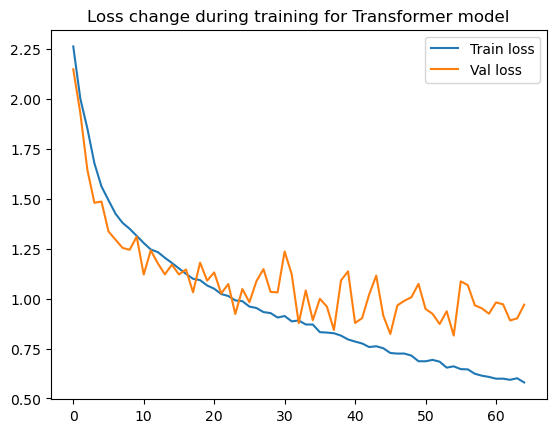

In [10]:
plt.plot(transformer_train_losses_1)
plt.plot(transformer_val_losses_1)
plt.title("Loss change during training for Transformer model")
plt.legend(["Train loss", "Val loss"])
plt.show()

### Transformer-1 evaluation

In [12]:
# _, train_acc_transformer_1 = calc_accuracy(X_train, y_train, transformer_model_1)
# print(f"Train accuracy: {train_acc_transformer_1}")

_, val_acc_transformer_1 = calc_accuracy(X_val, y_val, transformer_model_1)
print(f"Val accuracy: {val_acc_transformer_1}")

test_preds_transformer_1, test_acc_transformer_1 = calc_accuracy(X_test, y_test, transformer_model_1)
print(f"Test accuracy: {test_acc_transformer_1}")

Val accuracy: 0.8261544431509508
Test accuracy: 0.8102843786521231


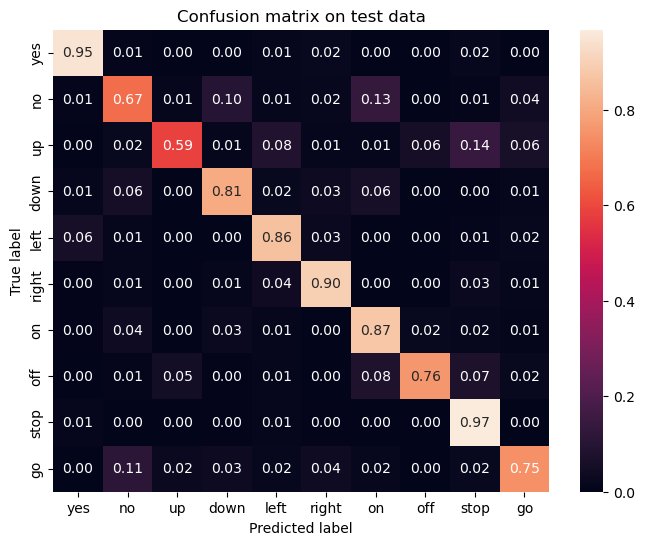

In [13]:
plt.figure(figsize=(8, 6))
result = confusion_matrix(y_test, test_preds_transformer_1, normalize='true')
sns.heatmap(result, annot=True, fmt='.2f', xticklabels=CLASSES, yticklabels=CLASSES)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix on test data')
plt.show()

## Transformer-2

In [7]:
d_model = 20
n_head = 4
num_class = 10
num_layers = 5
dropout = 0.3
fc_size = 512

transformer_model_2 = Transformer(d_model, n_head, num_layers, num_class, dropout, fc_size).to(device)
transformer_criterion_2 = nn.CrossEntropyLoss()
transformer_optimizer_2 = optim.Adam(transformer_model_2.parameters())

summary(transformer_model_2, (1, 99, 20))

Layer (type:depth-idx)                        Output Shape              Param #
Transformer                                   [1, 10]                   85,748
├─TransformerEncoder: 1-1                     [1, 99, 20]               --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 99, 20]               85,748
│    │    └─TransformerEncoderLayer: 3-2      [1, 99, 20]               85,748
│    │    └─TransformerEncoderLayer: 3-3      [1, 99, 20]               85,748
│    │    └─TransformerEncoderLayer: 3-4      [1, 99, 20]               85,748
│    │    └─TransformerEncoderLayer: 3-5      [1, 99, 20]               85,748
├─Dropout: 1-2                                [1, 20]                   --
├─BatchNorm1d: 1-3                            [1, 20]                   40
├─Linear: 1-4                                 [1, 512]                  10,752
├─Dropout: 1-5                                [1, 512]             

In [8]:
train_dl = transform_to_data_loader(X_train, y_train, device=device)
val_dl = transform_to_data_loader(X_val, y_val, device=device)

transformer_train_losses_2, transformer_val_losses_2 = train_model(
    model=transformer_model_2,
    criterion=transformer_criterion_2,
    optimizer=transformer_optimizer_2,
    train_loader=train_dl,
    val_loader=val_dl, 
    model_type="main", 
    epoch_count=200,
    device=device,
    early_stopping=True,
    patience=10
)

Epoch 1:   0%|          | 0/145 [00:00<?, ?it/s]c:\Users\lukgr\anaconda3\envs\venv\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
Epoch 1: 100%|██████████| 145/145 [00:18<00:00,  7.74it/s]


Epoch 1/200, Train Loss: 2.2812, Train Acc: 0.15, Val Loss: 1.9504, Val Acc: 0.24


Epoch 2: 100%|██████████| 145/145 [00:16<00:00,  8.57it/s]


Epoch 2/200, Train Loss: 1.8424, Train Acc: 0.31, Val Loss: 1.9277, Val Acc: 0.33


Epoch 3: 100%|██████████| 145/145 [00:17<00:00,  8.38it/s]


Epoch 3/200, Train Loss: 1.5412, Train Acc: 0.42, Val Loss: 1.2959, Val Acc: 0.53


Epoch 4: 100%|██████████| 145/145 [00:17<00:00,  8.31it/s]


Epoch 4/200, Train Loss: 1.3600, Train Acc: 0.50, Val Loss: 1.1921, Val Acc: 0.56


Epoch 5: 100%|██████████| 145/145 [00:17<00:00,  8.22it/s]


Epoch 5/200, Train Loss: 1.2284, Train Acc: 0.55, Val Loss: 1.2555, Val Acc: 0.56


Epoch 6: 100%|██████████| 145/145 [00:17<00:00,  8.15it/s]


Epoch 6/200, Train Loss: 1.1751, Train Acc: 0.57, Val Loss: 1.0746, Val Acc: 0.61


Epoch 7: 100%|██████████| 145/145 [00:17<00:00,  8.07it/s]


Epoch 7/200, Train Loss: 1.1365, Train Acc: 0.59, Val Loss: 1.3349, Val Acc: 0.58


Epoch 8: 100%|██████████| 145/145 [00:18<00:00,  8.05it/s]


Epoch 8/200, Train Loss: 1.0909, Train Acc: 0.61, Val Loss: 1.1010, Val Acc: 0.64


Epoch 9: 100%|██████████| 145/145 [00:18<00:00,  8.02it/s]


Epoch 9/200, Train Loss: 1.0416, Train Acc: 0.63, Val Loss: 1.0601, Val Acc: 0.65


Epoch 10: 100%|██████████| 145/145 [00:18<00:00,  7.99it/s]


Epoch 10/200, Train Loss: 1.0004, Train Acc: 0.65, Val Loss: 1.0350, Val Acc: 0.68


Epoch 11: 100%|██████████| 145/145 [00:18<00:00,  7.97it/s]


Epoch 11/200, Train Loss: 0.9739, Train Acc: 0.67, Val Loss: 0.9209, Val Acc: 0.70


Epoch 12: 100%|██████████| 145/145 [00:18<00:00,  7.79it/s]


Epoch 12/200, Train Loss: 0.9467, Train Acc: 0.68, Val Loss: 0.9325, Val Acc: 0.70


Epoch 13: 100%|██████████| 145/145 [00:18<00:00,  7.87it/s]


Epoch 13/200, Train Loss: 0.9106, Train Acc: 0.69, Val Loss: 0.9406, Val Acc: 0.72


Epoch 14: 100%|██████████| 145/145 [00:18<00:00,  7.84it/s]


Epoch 14/200, Train Loss: 0.8849, Train Acc: 0.71, Val Loss: 0.7908, Val Acc: 0.75


Epoch 15: 100%|██████████| 145/145 [00:18<00:00,  7.79it/s]


Epoch 15/200, Train Loss: 0.8555, Train Acc: 0.72, Val Loss: 0.7805, Val Acc: 0.77


Epoch 16: 100%|██████████| 145/145 [00:18<00:00,  8.00it/s]


Epoch 16/200, Train Loss: 0.8238, Train Acc: 0.73, Val Loss: 0.8576, Val Acc: 0.76


Epoch 17: 100%|██████████| 145/145 [00:17<00:00,  8.06it/s]


Epoch 17/200, Train Loss: 0.7963, Train Acc: 0.74, Val Loss: 0.9062, Val Acc: 0.77


Epoch 18: 100%|██████████| 145/145 [00:17<00:00,  8.06it/s]


Epoch 18/200, Train Loss: 0.7642, Train Acc: 0.76, Val Loss: 0.7516, Val Acc: 0.77


Epoch 19: 100%|██████████| 145/145 [00:18<00:00,  8.04it/s]


Epoch 19/200, Train Loss: 0.7450, Train Acc: 0.77, Val Loss: 0.8707, Val Acc: 0.78


Epoch 20: 100%|██████████| 145/145 [00:17<00:00,  8.07it/s]


Epoch 20/200, Train Loss: 0.7319, Train Acc: 0.77, Val Loss: 0.7982, Val Acc: 0.80


Epoch 21: 100%|██████████| 145/145 [00:17<00:00,  8.07it/s]


Epoch 21/200, Train Loss: 0.6940, Train Acc: 0.78, Val Loss: 0.7524, Val Acc: 0.81


Epoch 22: 100%|██████████| 145/145 [00:18<00:00,  7.93it/s]


Epoch 22/200, Train Loss: 0.6703, Train Acc: 0.79, Val Loss: 0.6973, Val Acc: 0.82


Epoch 23: 100%|██████████| 145/145 [00:18<00:00,  8.00it/s]


Epoch 23/200, Train Loss: 0.6598, Train Acc: 0.80, Val Loss: 0.7179, Val Acc: 0.82


Epoch 24: 100%|██████████| 145/145 [00:17<00:00,  8.08it/s]


Epoch 24/200, Train Loss: 0.6411, Train Acc: 0.80, Val Loss: 0.7145, Val Acc: 0.82


Epoch 25: 100%|██████████| 145/145 [00:17<00:00,  8.09it/s]


Epoch 25/200, Train Loss: 0.6259, Train Acc: 0.81, Val Loss: 0.8425, Val Acc: 0.80


Epoch 26: 100%|██████████| 145/145 [00:18<00:00,  8.03it/s]


Epoch 26/200, Train Loss: 0.6018, Train Acc: 0.82, Val Loss: 0.7675, Val Acc: 0.82


Epoch 27: 100%|██████████| 145/145 [00:18<00:00,  8.05it/s]


Epoch 27/200, Train Loss: 0.5895, Train Acc: 0.82, Val Loss: 0.8400, Val Acc: 0.82


Epoch 28: 100%|██████████| 145/145 [00:18<00:00,  8.03it/s]


Epoch 28/200, Train Loss: 0.5738, Train Acc: 0.83, Val Loss: 0.7955, Val Acc: 0.82


Epoch 29: 100%|██████████| 145/145 [00:18<00:00,  8.04it/s]


Epoch 29/200, Train Loss: 0.5725, Train Acc: 0.83, Val Loss: 0.7933, Val Acc: 0.82


Epoch 30: 100%|██████████| 145/145 [00:18<00:00,  7.79it/s]


Epoch 30/200, Train Loss: 0.5572, Train Acc: 0.84, Val Loss: 0.7458, Val Acc: 0.83


Epoch 31: 100%|██████████| 145/145 [00:18<00:00,  8.05it/s]


Epoch 31/200, Train Loss: 0.5371, Train Acc: 0.84, Val Loss: 0.7715, Val Acc: 0.83


Epoch 32: 100%|██████████| 145/145 [00:18<00:00,  8.04it/s]


Epoch 32/200, Train Loss: 0.5271, Train Acc: 0.84, Val Loss: 0.6531, Val Acc: 0.85


Epoch 33: 100%|██████████| 145/145 [00:18<00:00,  8.04it/s]


Epoch 33/200, Train Loss: 0.5227, Train Acc: 0.84, Val Loss: 0.8794, Val Acc: 0.81


Epoch 34: 100%|██████████| 145/145 [00:17<00:00,  8.07it/s]


Epoch 34/200, Train Loss: 0.5151, Train Acc: 0.85, Val Loss: 0.7538, Val Acc: 0.83


Epoch 35: 100%|██████████| 145/145 [00:18<00:00,  8.04it/s]


Epoch 35/200, Train Loss: 0.5091, Train Acc: 0.85, Val Loss: 0.7403, Val Acc: 0.84


Epoch 36: 100%|██████████| 145/145 [00:18<00:00,  7.87it/s]


Epoch 36/200, Train Loss: 0.4915, Train Acc: 0.85, Val Loss: 0.8828, Val Acc: 0.82


Epoch 37: 100%|██████████| 145/145 [00:18<00:00,  8.03it/s]


Epoch 37/200, Train Loss: 0.4863, Train Acc: 0.86, Val Loss: 0.6777, Val Acc: 0.85


Epoch 38: 100%|██████████| 145/145 [00:18<00:00,  8.04it/s]


Epoch 38/200, Train Loss: 0.4713, Train Acc: 0.86, Val Loss: 0.7635, Val Acc: 0.84


Epoch 39: 100%|██████████| 145/145 [00:18<00:00,  7.93it/s]


Epoch 39/200, Train Loss: 0.4609, Train Acc: 0.86, Val Loss: 0.7482, Val Acc: 0.84


Epoch 40: 100%|██████████| 145/145 [00:18<00:00,  8.03it/s]


Epoch 40/200, Train Loss: 0.4480, Train Acc: 0.87, Val Loss: 0.7965, Val Acc: 0.84


Epoch 41: 100%|██████████| 145/145 [00:18<00:00,  8.04it/s]


Epoch 41/200, Train Loss: 0.4586, Train Acc: 0.87, Val Loss: 0.7786, Val Acc: 0.84


Epoch 42: 100%|██████████| 145/145 [00:18<00:00,  7.96it/s]


Epoch 42/200, Train Loss: 0.4605, Train Acc: 0.87, Val Loss: 0.7514, Val Acc: 0.84
Early stopping


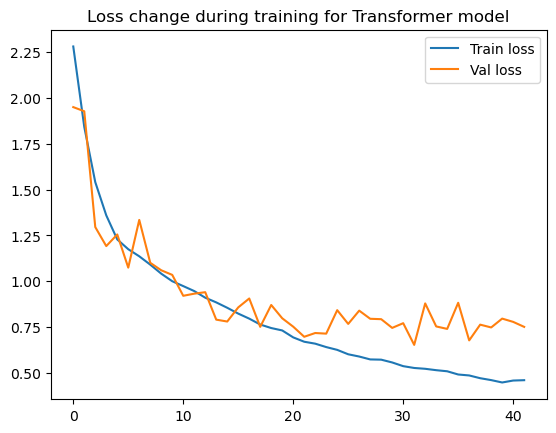

In [10]:
plt.plot(transformer_train_losses_2)
plt.plot(transformer_val_losses_2)
plt.title("Loss change during training for Transformer model")
plt.legend(["Train loss", "Val loss"])
plt.show()

### Transformer-2 evaluation

In [9]:
# _, train_acc_transformer_2 = calc_accuracy(X_train, y_train, transformer_model_2)
# print(f"Train accuracy: {train_acc_transformer_2}")

_, val_acc_transformer_2 = calc_accuracy(X_val, y_val, transformer_model_2)
print(f"Val accuracy: {val_acc_transformer_2}")

test_preds_transformer_2, test_acc_transformer_2 = calc_accuracy(X_test, y_test, transformer_model_2)
print(f"Test accuracy: {test_acc_transformer_2}")

Val accuracy: 0.843616608459449
Test accuracy: 0.835605765485002


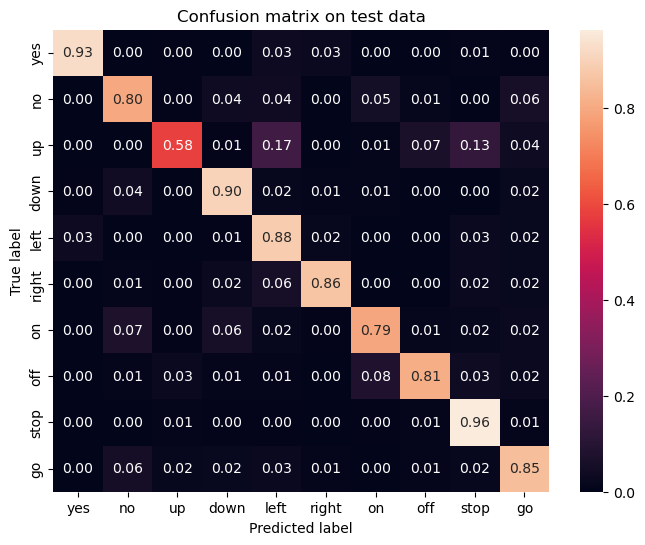

In [11]:
plt.figure(figsize=(8, 6))
result = confusion_matrix(y_test, test_preds_transformer_2, normalize='true')
sns.heatmap(result, annot=True, fmt='.2f', xticklabels=CLASSES, yticklabels=CLASSES)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix on test data')
plt.show()